# Data Integration

In [59]:
%matplotlib inline

In [1]:
import pandas as pd
import json
import os
try:
    from bs4 import BeautifulSoup
    import pandas_read_xml as pdx
    import tabula
    import statsmodels.api as sm
    from sklearn import linear_model
    from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, Normalizer
    from shapely.geometry import Point # Point class
    from shapely.geometry import shape # shape() is a function to convert geo objects through the interface
    import numpy as np
    import shapefile
    import seaborn as sns
except:
    !pip install pandas_read_xml xlrd tabula-py statsmodels Shapely shapefile bs4 numpy seaborn
    import seaborn as sns
    import pandas_read_xml as pdx
    from bs4 import BeautifulSoup
    import pandas_read_xml as pdx
    import tabula
    import statsmodels.api as sm
    from sklearn import linear_model
    from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, Normalizer
    from shapely.geometry import Point # Point class
    from shapely.geometry import shape # shape() is a function to convert geo objects through the interface
    import numpy as np
    import shapefile
from functools import reduce
from math import radians, cos, sin, asin, sqrt, atan2, pi 
from multiprocessing import Pool
sns.set(context="notebook", palette="Spectral", style = 'darkgrid' ,font_scale = 0.8, color_codes=True)

In [81]:
r = 6378
# The length of a degree in the equator in kms
deg_len = (2 * pi * r) / 360
# print(deg_len)
deg_len = 1


def distance(p1, p2):
    # distance in kilometers = euclidean distance * length of a degree in equator in kms
#     return round(np.linalg.norm(p2 - p1) * deg_len, 3)
    return round(np.linalg.norm(p2 - p1) , 3)

def between_times(time):
    time = [int(i) for i in time.split(':')]
    time_ = 3600 * time[0] + 60 * time[1] + time[2]
    if time_ > 3600 * 7 and time_ < 3600 * 9:
        return True
    return False

In [3]:
hospitals = open('29893909/hospitals.html')
hospitals = hospitals.read()
hospitals = pd.read_html(hospitals)[0].drop(['Unnamed: 0'], axis=1)

h_id = list(hospitals.id)
lat = [round(i, 6) for i in list(hospitals.lat)]
lng = [round(i, 6) for i in list(hospitals.lng)]
h_coordinates = [np.array((la, ln)) for la, ln in zip(lat, lng)]

In [4]:
supermarkets = pd.read_excel("29893909/supermarkets.xlsx").drop(['Unnamed: 0'], axis=1)
sm_id = list(supermarkets.id)
lat = [round(i, 6) for i in list(supermarkets.lat)]
lng = [round(i, 6) for i in list(supermarkets.lng)]
sm_coordinates = [np.array((la, ln)) for la, ln in zip(lat, lng)]

In [5]:
real_state = open('29893909/real_state.xml').read()[2:-1]
soup = BeautifulSoup(real_state)
tags = [item.name for item in soup.root.childGenerator()]
data = {}
for i, child in enumerate(soup.body.root.children):
    data[tags[i]] = []
    for grandchild in child.children:
        data[tags[i]].append(grandchild.text)
real_state_xml = pd.DataFrame(data, columns=tags)
real_state_json = pd.read_json('29893909/real_state.json')
real_state = real_state_json.append(real_state_xml)

In [6]:
shoppingcenters = tabula.read_pdf('29893909/shopingcenters.pdf', pages='all')
shoppingcenters = reduce(lambda a, b: a.append(b), shoppingcenters)

sc_id = list(shoppingcenters.sc_id)
lat = [round(i, 6) for i in list(shoppingcenters.lat)]
lng = [round(i, 6) for i in list(shoppingcenters.lng)]
sc_coordinates = [np.array((la, ln)) for la, ln in zip(lat, lng)]

In [7]:
stops = pd.read_csv("GTFS - Melbourne Train Information/stops.txt")
ts_id = list(stops.stop_id)
lat = [round(i, 6) for i in list(stops.stop_lat)]
lng = [round(i, 6) for i in list(stops.stop_lon)]
ts_coordinates = [np.array((la, ln)) for la, ln in zip(lat, lng)]

In [8]:
stop_times = pd.read_csv("GTFS - Melbourne Train Information/stop_times.txt")
calendar = pd.read_csv("GTFS - Melbourne Train Information/calendar.txt")
trips = pd.read_csv("GTFS - Melbourne Train Information/trips.txt")
routes = pd.read_csv("GTFS - Melbourne Train Information/routes.txt")
shapes = pd.read_csv("GTFS - Melbourne Train Information/shapes.txt")

In [9]:
def closest(location, id, coords):
    distances = [distance(location, coord) for coord in coords]
    return id[distances.index(min(distances))], min(distances)

def coord(df, index):
    return np.array((
        df.loc[index, 'lat'], 
        df.loc[index, 'lng']
    ))

In [10]:
# Appending empty columns to the dataframe and populating them with default values
lrs = len(real_state)
real_state['suburb'] = ["not available"]*lrs
real_state['Shopping_center_id'] = ["not available"]*lrs
real_state['Distance_to_sc'] = [0]*lrs
real_state['Train_station_id'] = ["not available"]*lrs
real_state['Distance_to_train_station'] = [0]*lrs
real_state['travel_min_to_CBD'] = [0]*lrs
real_state['Transfer_flag'] = [-1]*lrs
real_state['Hospital_id'] = ["not available"]*lrs
real_state['Distance_to_hospital'] = [0]*lrs
real_state['Supermarket_id'] = ["not available"]*lrs
real_state['Distance_to_supermarket'] = [0]*lrs

In [11]:
%%time
# handling cases where the hour in time > 24
# super inefficient: change if there is time
    
for index in stop_times[stop_times.arrival_time.str.match("24:\d{1,2}:\d{1,2}")].index:
    time = stop_times.loc[index, 'arrival_time'].split(":")
    time = ":".join(["00", time[1], time[2]])
    stop_times.loc[index, 'arrival_time'] = time


for index in stop_times[stop_times.departure_time.str.match("24:\d{1,2}:\d{1,2}")].index:
    time = stop_times.loc[index, 'departure_time'].split(":")
    time = ":".join(["00", time[1], time[2]])
    stop_times.loc[index, 'departure_time'] = time
    
for index in stop_times[stop_times.arrival_time.str.match("25:\d{1,2}:\d{1,2}")].index:
    time = stop_times.loc[index, 'arrival_time'].split(":")
    time = ":".join(["01", time[1], time[2]])
    stop_times.loc[index, 'arrival_time'] = time
    
for index in stop_times[stop_times.departure_time.str.match("25:\d{1,2}:\d{1,2}")].index:
    time = stop_times.loc[index, 'departure_time'].split(":")
    time = ":".join(["01", time[1], time[2]])
    stop_times.loc[index, 'departure_time'] = time
    
for index in stop_times[stop_times.arrival_time.str.match("26:\d{1,2}:\d{1,2}")].index:
    time = stop_times.loc[index, 'arrival_time'].split(":")
    time = ":".join(["02", time[1], time[2]])
    stop_times.loc[index, 'arrival_time'] = time
    
for index in stop_times[stop_times.departure_time.str.match("26:\d{1,2}:\d{1,2}")].index:
    time = stop_times.loc[index, 'departure_time'].split(":")
    time = ":".join(["02", time[1], time[2]])
    stop_times.loc[index, 'departure_time'] = time
    
stop_times['departure_time'] = pd.to_datetime(stop_times['departure_time'], format='%H:%M:%S').dt.time
stop_times['arrival_time'] = pd.to_datetime(stop_times['arrival_time'], format='%H:%M:%S').dt.time 

CPU times: user 1min 8s, sys: 129 ms, total: 1min 8s
Wall time: 1min 8s


In [12]:
start = pd.to_datetime("07:00:00", format="%H:%M:%S").time()
end = pd.to_datetime("09:00:00", format="%H:%M:%S").time()

stop_times_7_9 = stop_times[(stop_times['departure_time'] > start) & (stop_times['departure_time'] < end) & 
           (stop_times['arrival_time'] > start) &  (stop_times['arrival_time'] < end)]

In [13]:
trips_flinders_street = trips[trips.trip_headsign=='City (Flinders Street)']

In [14]:
# Transfer_flag
transfer_flag = {}
stop_times_trips = pd.merge(left=stop_times_7_9, right=trips_flinders_street, on='trip_id')
for stop in list(stops.stop_id):
    if not stop_times_trips[stop_times_trips.stop_id == stop].empty:
        transfer_flag[stop] = 0

In [15]:
routes

,route_id,agency_id,route_short_name,route_long_name,route_type
0,2-ALM-B-mjp-1,1,Alamein,Alamein - City (Flinders Street),2
1,2-ALM-C-mjp-1,1,Alamein,Alamein - City (Flinders Street),2
2,2-ALM-D-mjp-1,1,Alamein,Alamein - City (Flinders Street),2
3,2-ALM-E-mjp-1,1,Alamein,Alamein - City (Flinders Street),2
4,2-ALM-F-mjp-1,1,Alamein,Alamein - City (Flinders Street),2
...,...,...,...,...,...
76,2-WMN-B-mjp-1,1,Williamstown,Williamstown - City (Flinders Street),2
77,2-WMN-C-mjp-1,1,Williamstown,Williamstown - City (Flinders Street),2
78,2-WMN-D-mjp-1,1,Williamstown,Williamstown - City (Flinders Street),2
79,2-WMN-E-mjp-1,1,Williamstown,Williamstown - City (Flinders Street),2


In [16]:
trips

,route_id,service_id,trip_id,shape_id,trip_headsign,direction_id
0,2-ALM-F-mjp-1,T0,17067982.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
1,2-ALM-F-mjp-1,T0,17067988.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
2,2-ALM-F-mjp-1,T0,17067992.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
3,2-ALM-F-mjp-1,T0,17067999.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
4,2-ALM-F-mjp-1,T0,17068003.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
...,...,...,...,...,...,...
23804,2-WMN-F-mjp-1,UJ_2,17072252.UJ.2-WMN-F-mjp-1.6.R,2-WMN-F-mjp-1.6.R,Williamstown,1
23805,2-WMN-F-mjp-1,UJ_2,17072256.UJ.2-WMN-F-mjp-1.6.R,2-WMN-F-mjp-1.6.R,Williamstown,1
23806,2-WMN-F-mjp-1,UJ_2,17072260.UJ.2-WMN-F-mjp-1.6.R,2-WMN-F-mjp-1.6.R,Williamstown,1
23807,2-WMN-F-mjp-1,UJ_2,17072264.UJ.2-WMN-F-mjp-1.6.R,2-WMN-F-mjp-1.6.R,Williamstown,1


## Suburb
Iterate through all the polygons in the given shapefile to find the suburb a given property lies in.

In [18]:
# Suburb
shp = shapefile.Reader('vic_suburb_boundary/VIC_LOCALITY_POLYGON_shp.dbf') #open the shapefile
all_shapes = shp.shapes() # get all the polygons
all_records = shp.records()     

def get_suburb(inp):
#     point, property_id = inp
    try:
        property_id, point = inp
        for i in range(len(all_shapes)):
            boundary = all_shapes[i] # get a boundary polygon
            if Point(point).within(shape(boundary)):
                return (property_id, all_records[i].as_dict()['VIC_LOCA_2'])
        return ("", "")
    except:
        pass

In [19]:
# Locating the suburb a property is situated in 
if 'prop2sub.json' not in os.listdir("."):
    lat = list(real_state.lat)
    lng = list(real_state.lng)
    coords = [(i, j) for i, j in zip(lng, lat)]
    property_ids = list(real_state.property_id)
    inp = [(pid, coord) for pid, coord in zip(property_ids, coords)]
    
    with Pool(4) as p:
        property2suburb = p.map(get_suburb, inp)
else:
    with open('prop2sub.json', 'r') as f:
        property2suburb = json.load(f)
    prop2sub = {}
    for i in property2suburb:
        try:
            prop2sub[i[0]] = i[1]
        except:
            pass

In [20]:
def in_weekdays(service_id):
    temp = 0
    for i in ["monday", "tuesday", "wednesday", "thursday", "friday"]: 
        temp += calendar[calendar.service_id==service_id][i].values[0]
    if temp > 0:
        return True
    return False

In [21]:
stop_times

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,17182517.T2.2-ALM-B-mjp-1.1.H,04:57:00,04:57:00,19847,1,NaN,0,0,0.000000
1,17182517.T2.2-ALM-B-mjp-1.1.H,04:58:00,04:58:00,19848,2,NaN,0,0,723.017818
2,17182517.T2.2-ALM-B-mjp-1.1.H,05:00:00,05:00:00,19849,3,NaN,0,0,1951.735072
3,17182517.T2.2-ALM-B-mjp-1.1.H,05:02:00,05:02:00,19850,4,NaN,0,0,2899.073349
4,17182517.T2.2-ALM-B-mjp-1.1.H,05:04:00,05:04:00,19851,5,NaN,0,0,3927.090952
...,...,...,...,...,...,...,...,...,...
390300,17199140.UJ.2-ain-mjp-1.4.R,18:09:00,18:09:00,20028,1,NaN,0,0,0.000000
390301,17199140.UJ.2-ain-mjp-1.4.R,18:15:00,18:15:00,19973,4,NaN,0,0,4011.161109
390302,17199140.UJ.2-ain-mjp-1.4.R,18:19:00,18:19:00,22180,5,NaN,0,0,5676.741894
390303,17199142.T2.2-ain-mjp-1.5.R,00:00:00,00:00:00,20027,1,NaN,0,0,0.000000


In [58]:
# %%time
# # Checking for stops where multiple trains were taken to reach Flinders Street
sids = list(stops.stop_id.unique())
for sid in sids:
    tids = list(stop_times_7_9[stop_times_7_9.stop_id == sid].trip_id.unique())
    for tid in tids:
        l = list(trips[trips.trip_id == tid].route_id.unique())
        if len(l) > 1:
            print(sid)

In [23]:
# Only direct trains were found from all stops to Flinders Street

def travel_min_to_CBD(stop_id):
    times = []
    ts = list(stop_times_7_9[stop_times_7_9.stop_id == stop_id].trip_id.unique())
    # Ignoring all trips that don't occur on weekdays
    for t in ts:
        sid = trips[trips.trip_id == t].service_id.values[0]
        if not in_weekdays(sid):
            ts.remove(t)
            
    for t in ts:
        try:
            st_time = stop_times_7_9[(stop_times_7_9.trip_id == t) & (stop_times_7_9.stop_id == stop_id)].departure_time
            re_time = stop_times_7_9[(stop_times_7_9.trip_id == t) & (stop_times_7_9.stop_id == 19854)].arrival_time
            re_time = pd.to_datetime(re_time, format='%H:%M:%S').values[0]
            st_time = pd.to_datetime(st_time, format='%H:%M:%S').values[0]
            times.append(pd.Timedelta(re_time - st_time).seconds / 60)
        except Exception as e:
            pass
    try:
        return (stop_id, round(sum(times) / len(times), 2))
    except:
        return (stop_id, None)

In [24]:
%%time
stop_ids = list(stops.stop_id.unique())
with Pool(4) as p:
    stopid2cbd = p.map(travel_min_to_CBD, stop_ids)

CPU times: user 59.8 ms, sys: 52.1 ms, total: 112 ms
Wall time: 2min 7s


In [25]:
stid2cbd = {}
for i in stopid2cbd:
    try:
        stid2cbd[i[0]] = i[1]
    except:
        pass

In [26]:
for i in list(stid2cbd.keys()):
    if stid2cbd[i] is None:
        print(stops[stops.stop_id == i].stop_name)

2    Stony Point Railway Station
Name: stop_name, dtype: object
3    Crib Point Railway Station
Name: stop_name, dtype: object
4    Morradoo Railway Station
Name: stop_name, dtype: object
5    Bittern Railway Station
Name: stop_name, dtype: object
6    Hastings Railway Station
Name: stop_name, dtype: object
7    Tyabb Railway Station
Name: stop_name, dtype: object
8    Somerville Railway Station
Name: stop_name, dtype: object
9    Baxter Railway Station
Name: stop_name, dtype: object
11    Leawarra Railway Station
Name: stop_name, dtype: object
195    Flemington Racecourse Railway Station
Name: stop_name, dtype: object
196    Showgrounds Railway Station
Name: stop_name, dtype: object


In [27]:
%%time
for index in real_state.index:
    try:
        lat = round(real_state.loc[index, 'lat'].values[0], 4)
        lng = round(real_state.loc[index, 'lng'].values[0], 4)
        real_state.loc[index, 'lat'] = lat
        real_state.loc[index, 'lng'] = lng
    except:
        lat = round(real_state.loc[index, 'lat'], 4)
        lng = round(real_state.loc[index, 'lng'], 4)
        real_state.loc[index, 'lat'] = lat
        real_state.loc[index, 'lng'] = lng

CPU times: user 2.22 s, sys: 51 µs, total: 2.22 s
Wall time: 2.22 s


In [170]:
%%time
for index in real_state.index:
    try:
        try:
            lat = real_state.loc[index, 'lat'].values[0]
            lng = real_state.loc[index, 'lng'].values[0]
            lat, lng = float(lat), float(lng)
            location = np.array((lat, lng))
        except:
            lat = real_state.loc[index, 'lat']
            lng = real_state.loc[index, 'lng']
            lat, lng = float(lat), float(lng)
            location = np.array((lat, lng))
            print(location)
            
        try:
            real_state.loc[index, 'suburb'] = prop2sub[real_state.loc[index, 'property_id'].values[0]]
        except Exception as e:
            real_state.loc[index, 'suburb'] = prop2sub[real_state.loc[index, 'property_id']]
        
        id, dist = closest(location, sc_id, sc_coordinates)
        real_state.loc[index, 'Shopping_center_id'] = id
        real_state.loc[index, 'Distance_to_sc'] = dist
        
        id, dist = closest(location, ts_id, ts_coordinates)
        real_state.loc[index, 'Train_station_id'] = id
        real_state.loc[index, 'Distance_to_train_station'] = dist
        
        real_state.loc[index, 'Transfer_flag'] = transfer_flag[id]
        try:
            real_state.loc[index, 'travel_min_to_CBD'] = stid2cbd[id]
        except Exception as e:
            print(e, index)
            print(real_state.loc[index])
            real_state.loc[index, 'travel_min_to_CBD'] = 0
            
        
        id, dist = closest(location, h_id, h_coordinates)
        real_state.loc[index, 'Hospital_id'] = id
        real_state.loc[index, 'Distance_to_hospital'] = dist

        id, dist = closest(location, sm_id, sm_coordinates)
        real_state.loc[index, 'Supermarket_id'] = id
        real_state.loc[index, 'Distance_to_supermarket'] = dist
    except Exception as e:
        real_state.loc[index]

[-37.7863 144.8826]
[-37.7123 145.0991]
[-37.7601 144.9872]
[-37.9119 145.0037]
[-37.865  145.0945]
[-37.6971 145.0934]
[-37.8132 145.1897]
[-37.7286 144.9945]
[-37.6939 145.0528]
CPU times: user 22.7 s, sys: 55.8 ms, total: 22.8 s
Wall time: 22.8 s


In [172]:
for index in real_state.index:
    try:
        dth = real_state.loc[index, 'Distance_to_hospital'].values[0]
        dts = real_state.loc[index, 'Distance_to_sc'].values[0]
    except:
        dth = real_state.loc[index, 'Distance_to_hospital']
        dts = real_state.loc[index, 'Distance_to_sc']
    real_state.loc[index, 'Distance_to_hospital'] = float(dth)
    real_state.loc[index, 'Distance_to_sc'] = float(dts)

In [173]:
real_state.columns

Index(['property_id', 'lat', 'lng', 'addr_street', 'price', 'property_type',
       'year', 'bedrooms', 'bathrooms', 'parking_space', 'suburb',
       'Shopping_center_id', 'Distance_to_sc', 'Train_station_id',
       'Distance_to_train_station', 'travel_min_to_CBD', 'Transfer_flag',
       'Hospital_id', 'Distance_to_hospital', 'Supermarket_id',
       'Distance_to_supermarket'],
      dtype='object')

In [174]:
cols = ['property_id', 'lat', 'lng', 'price', 'year', 'bedrooms', 'bathrooms', 'parking_space', 
      'Distance_to_sc', 'Train_station_id', 'Distance_to_train_station', 'travel_min_to_CBD', 
        'Transfer_flag', 'Distance_to_hospital', 'Distance_to_supermarket']

In [175]:
for col in cols:
    real_state[col] = pd.to_numeric(real_state[col])

In [32]:
columns = ['Distance_to_sc', 'Distance_to_hospital', 'travel_min_to_CBD', 'price']
X_cols = ['Distance_to_sc', 'Distance_to_hospital', 'travel_min_to_CBD']

In [33]:
real_state.price = pd.to_numeric(real_state.price)

In [34]:
real_state

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space,...,Shopping_center_id,Distance_to_sc,Train_station_id,Distance_to_train_station,travel_min_to_CBD,Transfer_flag,Hospital_id,Distance_to_hospital,Supermarket_id,Distance_to_supermarket
0,41387,-37.7451,145.0648,1/46 Hillside Road,7200000,house,2015,3,2,2,...,SC_017,0.011,19936,0.003,524.98,0,hospital_004,0.011,S_100,0.015
1,72107,-37.8387,145.2627,19 CHURCH STREET,19550000,house,2008,3,2,2,...,SC_032,0.043,19870,0.006,410.37,0,hospital_002,0.018,S_139,0.006
2,51703,-37.7807,145.1241,84 Williamsons Road,9630000,house,2013,3,1,2,...,SC_091,0.007,20042,0.039,548.82,0,hospital_193,0.012,S_188,0.006
3,37969,-37.7756,145.0195,126 Arthur Street,7380000,house,2014,3,2,0,...,SC_001,0.024,19930,0.004,623.91,0,hospital_029,0.015,S_219,0.023
4,92396,-37.9746,145.0612,68 Latrobe street,12558000,house,2015,3,1,2,...,SC_003,0.028,19865,0.008,534.16,0,hospital_133,0.009,S_011,0.007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,24209,-37.9030,145.0451,24 Beccles Street,7684000,house,2011,3,1,1,...,SC_041,0.023,19941,0.005,815.36,0,hospital_126,0.026,S_107,0.017
997,80370,-37.8518,145.2345,56 Putt Grove,9975000,house,2016,4,2,2,...,SC_032,0.039,19871,0.026,408.25,0,hospital_179,0.007,S_226,0.021
998,75144,-37.7188,145.0881,4/26A Howe Street,3618000,house,2009,2,1,1,...,SC_017,0.042,19984,0.009,576.97,0,hospital_075,0.022,S_020,0.018
999,80699,-37.6505,145.0487,10 McNab Court,3036000,house,2008,3,1,1,...,SC_062,0.037,45795,0.018,582.90,0,hospital_053,0.032,S_096,0.025


# Data Reshaping

## Standardization

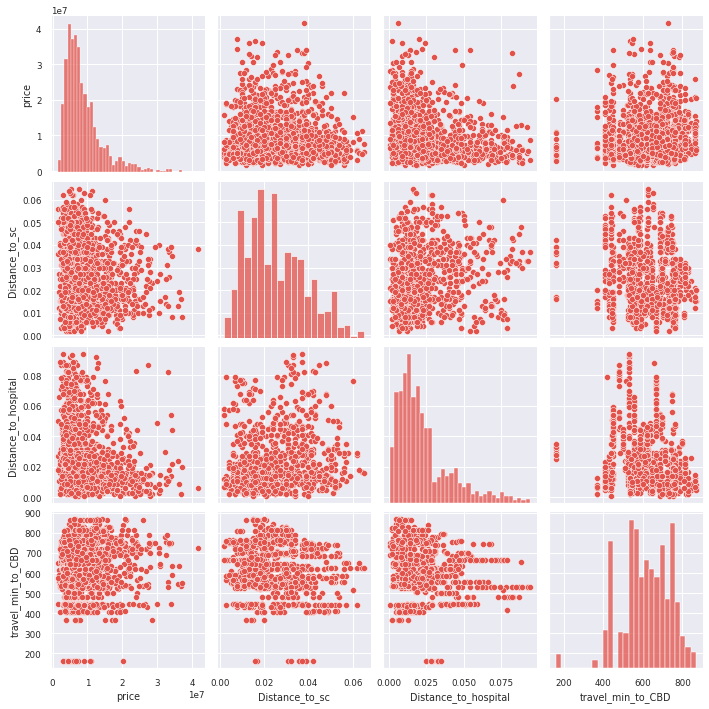

In [143]:
sns.pairplot(real_state[columns])

From the above grid of scatterplots, it is visible that while Distance_to_sc and Distance_to_hospital have a roughly inverse relationship with the price, travel_min_to_CBD does not. 

In [177]:
standard_scaler = StandardScaler()
real_state_standard = real_state.copy()
columns = ['price', 'Distance_to_sc', 'Distance_to_hospital', 'travel_min_to_CBD']
real_state_standard[columns] = standard_scaler.fit_transform(real_state_standard[columns])

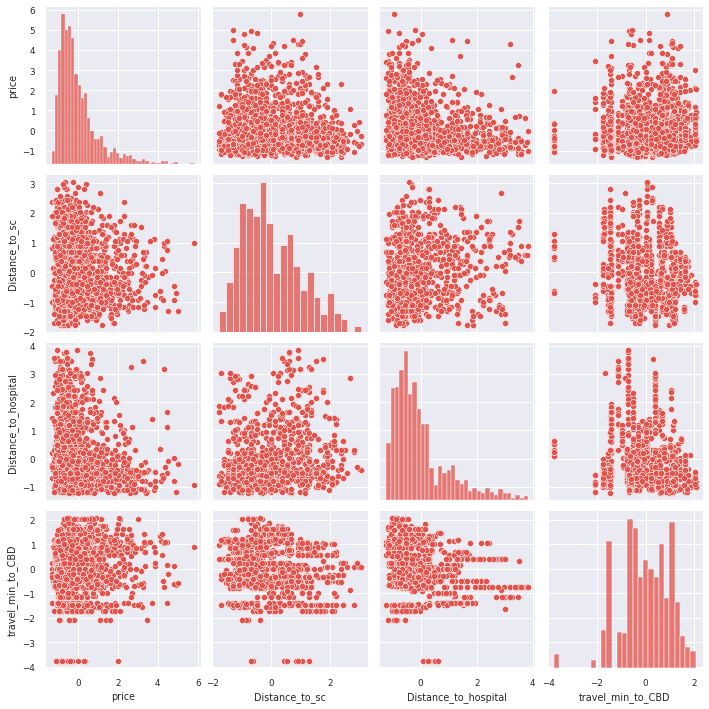

In [178]:
p = sns.pairplot(real_state_standard[columns])

In [159]:
def outlier_numeric(df, Data):
    return df[np.abs(df[Data]-df[Data].mean()) <= (3*df[Data].std())]

In [160]:
df  = outlier_numeric(real_state, 'travel_min_to_CBD')

In [161]:
df

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space,...,Shopping_center_id,Distance_to_sc,Train_station_id,Distance_to_train_station,travel_min_to_CBD,Transfer_flag,Hospital_id,Distance_to_hospital,Supermarket_id,Distance_to_supermarket
0,41387,-37.7451,145.0648,1/46 Hillside Road,7200000,house,2015,3,2,2,...,SC_017,0.011,19936,0.003,524.98,0,hospital_004,0.011,S_100,0.015
1,72107,-37.8387,145.2627,19 CHURCH STREET,19550000,house,2008,3,2,2,...,SC_032,0.043,19870,0.006,410.37,0,hospital_002,0.018,S_139,0.006
2,51703,-37.7807,145.1241,84 Williamsons Road,9630000,house,2013,3,1,2,...,SC_091,0.007,20042,0.039,548.82,0,hospital_193,0.012,S_188,0.006
3,37969,-37.7756,145.0195,126 Arthur Street,7380000,house,2014,3,2,0,...,SC_001,0.024,19930,0.004,623.91,0,hospital_029,0.015,S_219,0.023
4,92396,-37.9746,145.0612,68 Latrobe street,12558000,house,2015,3,1,2,...,SC_003,0.028,19865,0.008,534.16,0,hospital_133,0.009,S_011,0.007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,24209,-37.9030,145.0451,24 Beccles Street,7684000,house,2011,3,1,1,...,SC_041,0.023,19941,0.005,815.36,0,hospital_126,0.026,S_107,0.017
997,80370,-37.8518,145.2345,56 Putt Grove,9975000,house,2016,4,2,2,...,SC_032,0.039,19871,0.026,408.25,0,hospital_179,0.007,S_226,0.021
998,75144,-37.7188,145.0881,4/26A Howe Street,3618000,house,2009,2,1,1,...,SC_017,0.042,19984,0.009,576.97,0,hospital_075,0.022,S_020,0.018
999,80699,-37.6505,145.0487,10 McNab Court,3036000,house,2008,3,1,1,...,SC_062,0.037,45795,0.018,582.90,0,hospital_053,0.032,S_096,0.025


<AxesSubplot:>

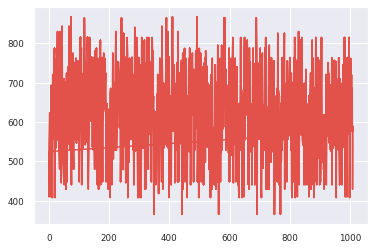

In [163]:
df.travel_min_to_CBD.plot()

In [113]:
minmax_scaler = MinMaxScaler(feature_range=(0, 1))
real_state_minmax = real_state.copy()
real_state_minmax[X_cols] = standard_scaler.fit_transform(real_state_minmax[X_cols])

In [114]:
# real_state_minmax.Distance_to_hospital = standard_scaler.fit_transform(real_state_minmax[['Distance_to_hospital']])

In [125]:
import matplotlib.pyplot as plt

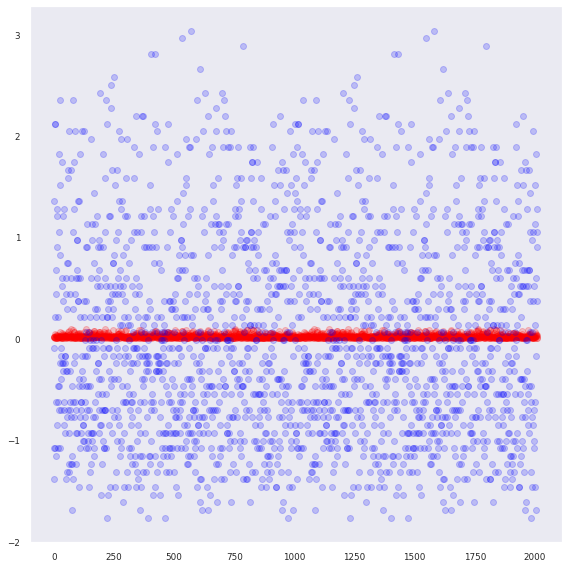

In [142]:
plt.figure(figsize=(8, 8))
plt.scatter(list(range(len(real_state))), real_state.Distance_to_hospital, color='red', alpha=0.2)
plt.scatter(list(range(len(real_state_standard))), real_state_standard.Distance_to_hospital,  
    color='blue', alpha=0.2)
plt.grid()
plt.tight_layout()
plt.show()

In [164]:
for index in real_state.index:
    try:
        dth = real_state.loc[index, 'Distance_to_hospital'].values[0]
        drs = real_state.loc[index, 'Distance_to_sc'].values[0]
    except:
        dth = real_state.loc[index, 'Distance_to_hospital']
        dts = real_state.loc[index, 'Distance_to_sc']
    real_state.loc[index, 'Distance_to_hospital'] = float(dth)
    real_state.loc[index, 'Distance_to_sc'] = float(dts)

In [118]:
# log_normalized = real_state.copy()
# for index in log_normalized.index:
#     for column in columns:
#         val = log_normalized.loc[index, column]
#         try:
#             log_normalized.loc[index, column] = np.log(val)
#         except:
#             log_normalized.loc[index, column] = np.log(val.values[0])

In [119]:
# log_normalized[columns]

In [120]:
real_state_boxcox = real_state.copy()
pt = PowerTransformer(method='box-cox')
normalizer = Normalizer()

real_state_boxcox[columns] = normalizer.fit_transform(real_state_boxcox[columns])
# real_state_boxcox[[columns]] = pt.fit_transform(real_state_boxcox[columns])
columns

['price', 'Distance_to_sc', 'Distance_to_hospital', 'travel_min_to_CBD']

In [121]:
X = real_state[['Distance_to_sc', 'Distance_to_hospital', 'travel_min_to_CBD']]
y = real_state['price']

X_bc = real_state_boxcox[['Distance_to_sc', 'Distance_to_hospital', 'travel_min_to_CBD']]
y_bc = real_state_boxcox['price']

In [122]:
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model_bc = sm.OLS(y_bc, X_bc).fit()
predictions = model_bc.predict(X_bc)

In [123]:
X.describe()

,Distance_to_sc,Distance_to_hospital,travel_min_to_CBD
count,2011.000000,2011.000000,2011.000000
mean,0.025211,0.025211,618.033342
std,0.013113,0.013113,121.230714
min,0.002000,0.002000,160.840000
25%,0.015000,0.015000,543.715000
50%,0.023000,0.023000,618.830000
75%,0.034000,0.034000,710.170000
max,0.065000,0.065000,867.710000


In [50]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.714
Model:                            OLS   Adj. R-squared (uncentered):              0.714
Method:                 Least Squares   F-statistic:                              1672.
Date:                Mon, 23 Nov 2020   Prob (F-statistic):                        0.00
Time:                        17:17:12   Log-Likelihood:                         -34125.
No. Observations:                2011   AIC:                                  6.826e+04
Df Residuals:                    2008   BIC:                                  6.827e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Distance_to_sc        2.454e+07   9.09e+06      2.700      0.007    6.72e+06    4.24e+07
Distance_to_hospital -1.746e+07    6.7e+06     -2.605      0.009   -3.06e+07   -4.31e+06
travel_min_to_CBD     1.388e+04    414.962     33.437      0.000    1.31e+04    1.47e+04
==============================================================================
Omnibus:                      686.030   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2326.548
Skew:                           1.699   Prob(JB):                         0.00
Kurtosis:                       7.028   Cond. No.                     4.72e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 4.72e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [51]:
# Linear Regression without transformation

In [52]:
lm = linear_model.LinearRegression()
lm_bc = linear_model.LinearRegression()
l_model = lm.fit(X, y)
l_bc = lm_bc.fit(X_bc, y_bc)

In [53]:
predictions = lm.predict(X)
predictions_bc = lm_bc.predict(X_bc)

In [54]:
lm_bc.score(X, y)

-2.5436397754218114

In [55]:
X = real_state_minmax[['Distance_to_sc', 'Distance_to_hospital', 'travel_min_to_CBD']]
y = real_state_minmax['price']

In [56]:
lm = linear_model.LinearRegression()
l_model = lm.fit(X, y)
predictions = lm.predict(X)
lm.score(X, y)

0.033244191887665586

In [ ]:
real_state.bedrooms.unique()